# TensorRT로 스테이블 디퓨전 가속하기

## 도커 이미지 빌드하기

먼저 해당 튜토리얼을 진행하기 위해 필요한 도커 이미지들을 빌드해줍시다. 제한된 시간 안에 튜토리얼을 마치기 위해서는 1분1초가 소중하니깐요!


먼저 아래의 커맨드를 통해 TensorRT 변환을 위해 필요한 도커 이미지를 가져와줍니다.

```bash
docker pull nvcr.io/nvidia/tensorrt:23.10-py3
```

그 다음 Triton Inferenecer Server를 이용하기 위한 도커 이미지를 아래와 같이 `Dockerfile`을 만들어 빌드해줍니다.

```Dockerfile
FROM nvcr.io/nvidia/tritonserver:23.10-py3
# transformers는 tokenizer를 사용하기 위해 인스톨합니다.
RUN pip install transformers==4.35.0
```

```bash
docker build --tag triton .
```

- 중요한 것은 이 때 가급적이면 `tritonserver` 이미지와 `tensorrt` 이미지의 `tag`를 맞춰주시는 것을 권장한다는 점입니다.
- 위의 예시에서는 `23.10-py3`로 맞춰줬는데, 이렇게 해야 버전 충돌의 가능성을 낮출 수 있습니다.
- 또한 `23.10-py3`의 경우 CUDA 12.2.2 버전을 베이스로 하고, 535 이상의 NVIDIA Driver를 요구하는데, 결국 어떠한 버전의 이미지를 사용할 것인가는 본인의 환경에 맞춰서 조정해주시는 것을 권장합니다.


> 참고로 `23.10-py3`는 TensorRT 8.6 버전이 사용되며, 해당 버전의 TensorRT는 17버전까지의 OnnxOpset이 지원됩니다. 
> 1. [참고1](https://docs.nvidia.com/deeplearning/tensorrt/container-release-notes/index.html#rel-23-10) 
> 2. [참고2](https://github.com/onnx/onnx-tensorrt/blob/main/docs/operators.md)

## 도커 이미지 빌드하기

먼저 해당 튜토리얼을 진행하기 위해 필요한 도커 이미지들을 빌드해줍시다. 제한된 시간 안에 튜토리얼을 마치기 위해서는 1분1초가 소중하니깐요!


먼저 아래의 커맨드를 통해 TensorRT 변환을 위해 필요한 도커 이미지를 가져와줍니다.

```bash
docker pull nvcr.io/nvidia/tensorrt:23.10-py3
```

그 다음 Triton Inferenecer Server를 이용하기 위한 도커 이미지를 아래와 같이 `Dockerfile`을 만들어 빌드해줍니다.

```Dockerfile
FROM nvcr.io/nvidia/tritonserver:23.10-py3
# transformers는 tokenizer를 사용하기 위해 인스톨합니다.
RUN pip install transformers==4.35.0
```

```bash
docker build --tag triton .
```

- 중요한 것은 이 때 가급적이면 `tritonserver` 이미지와 `tensorrt` 이미지의 `tag`를 맞춰주시는 것을 권장한다는 점입니다.
- 위의 예시에서는 `23.10-py3`로 맞춰줬는데, 이렇게 해야 버전 충돌의 가능성을 낮출 수 있습니다.
- 또한 `23.10-py3`의 경우 CUDA 12.2.2 버전을 베이스로 하고, 535 이상의 NVIDIA Driver를 요구하는데, 결국 어떠한 버전의 이미지를 사용할 것인가는 본인의 환경에 맞춰서 조정해주시는 것을 권장합니다.


> 참고로 `23.10-py3`는 TensorRT 8.6 버전이 사용되며, 해당 버전의 TensorRT는 17버전까지의 OnnxOpset이 지원됩니다. 
> 1. [참고1](https://docs.nvidia.com/deeplearning/tensorrt/container-release-notes/index.html#rel-23-10) 
> 2. [참고2](https://github.com/onnx/onnx-tensorrt/blob/main/docs/operators.md)

## 진행 과정

본 튜토리얼은 다음과 같은 과정으로 진행될 예정입니다.

1. 허깅페이스 [🧨Diffusers](https://huggingface.co/docs/diffusers/en/index) 라이브러리를 통해 스테이블 디퓨전 파이프라인을 구성하는 컴포넌트들을 불러옵니다.
2. 본 튜토리얼에서는 허깅페이스 허브에 공개된 ["segmind/tiny-sd"](https://huggingface.co/segmind/tiny-sd) 파이프라인을 사용하려고 합니다.
3. 해당 컴포넌트들을 TensorRT로 변환합니다.
4. [Triton Inference Server](https://developer.nvidia.com/triton-inference-server)를 통해 서빙해봅니다.

그렇다면 먼저 Diffusers 라이브러리를 설치해봅시다.

In [ ]:
%pip install diffusers transformers

## Stable Diffusion Pipeline의 간단한 소개

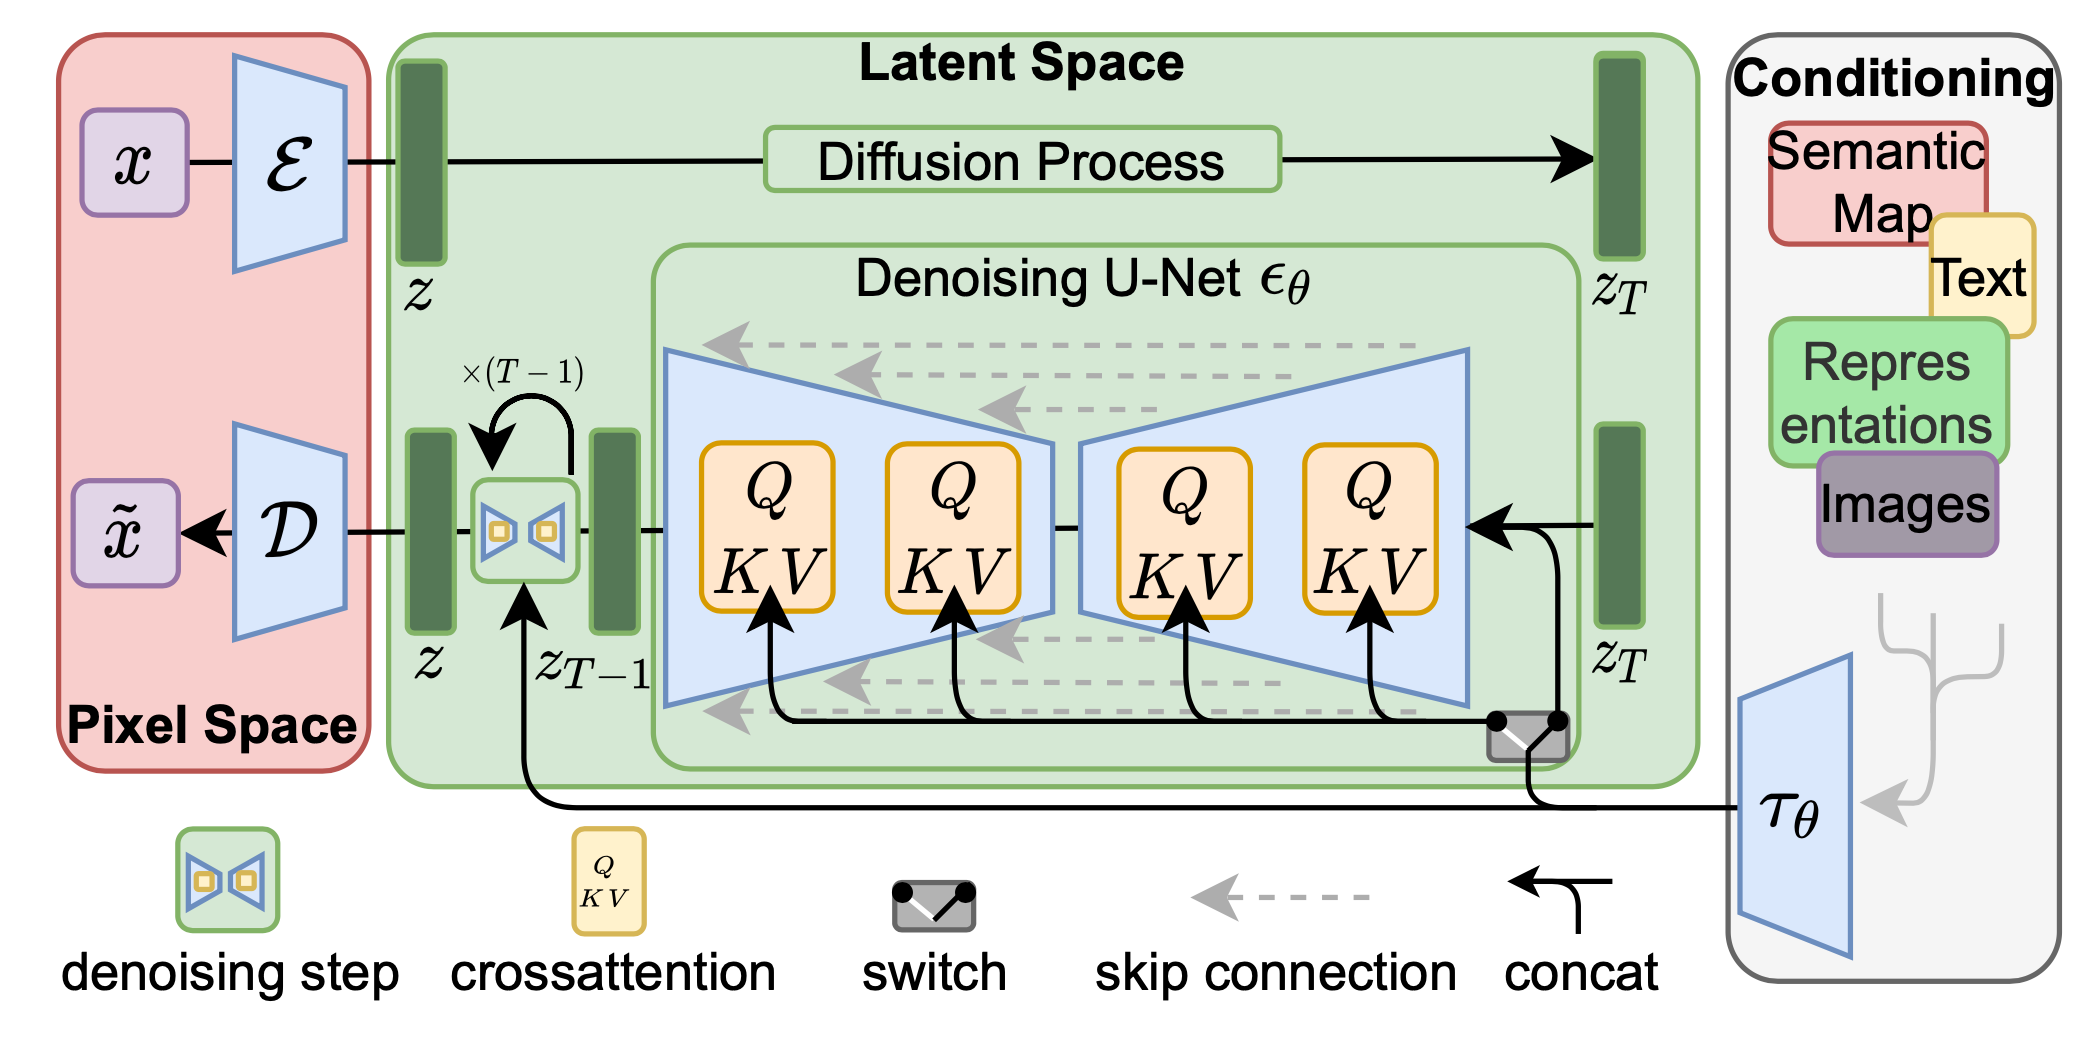

(Image source: [Rombach & Blattmann, et al. 2022](https://arxiv.org/abs/2112.01075))

스테이블 디퓨전 파이프라인은 다음과 같은 컴포넌트들로 구성됩니다.

1. **UNet** : Noisy한 latent tensor를 denoising하는 역할을 합니다.
2. **Text Encoder** : UNet의 denoising process에 텍스트 프롬프트에 기반한 guidance를 제공합니다. 
3. **VAE Decoder** : UNet을통해 Denoising이 완료된 latent tensor를 이미지로 복원합니다. (참고로 이번 튜토리얼에서는 Inference만 진행할 것이기 때문에 Encoder 파트는 필요하지 않습니다 🙂)
4. **Tokenizer** : Text Encoder에 전달될 프롬프트를 토크나이징합니다.
5. **Scheduler** : UNet을 통한 디노이징 프로세스 전반을 관리하는 역할을 합니다. 다양한 디노이징 알고리즘들이 있는데, 이번 튜토리얼에서는 DDPM 스케줄러를 사용하려고 합니다.

여기서 저희가 TensorRT로 변환할 컴포넌트는 **UNet, Text Encoder** 그리고 **VAE Decoder**입니다.

## 허깅페이스 허브로부터 UNet 불러오기

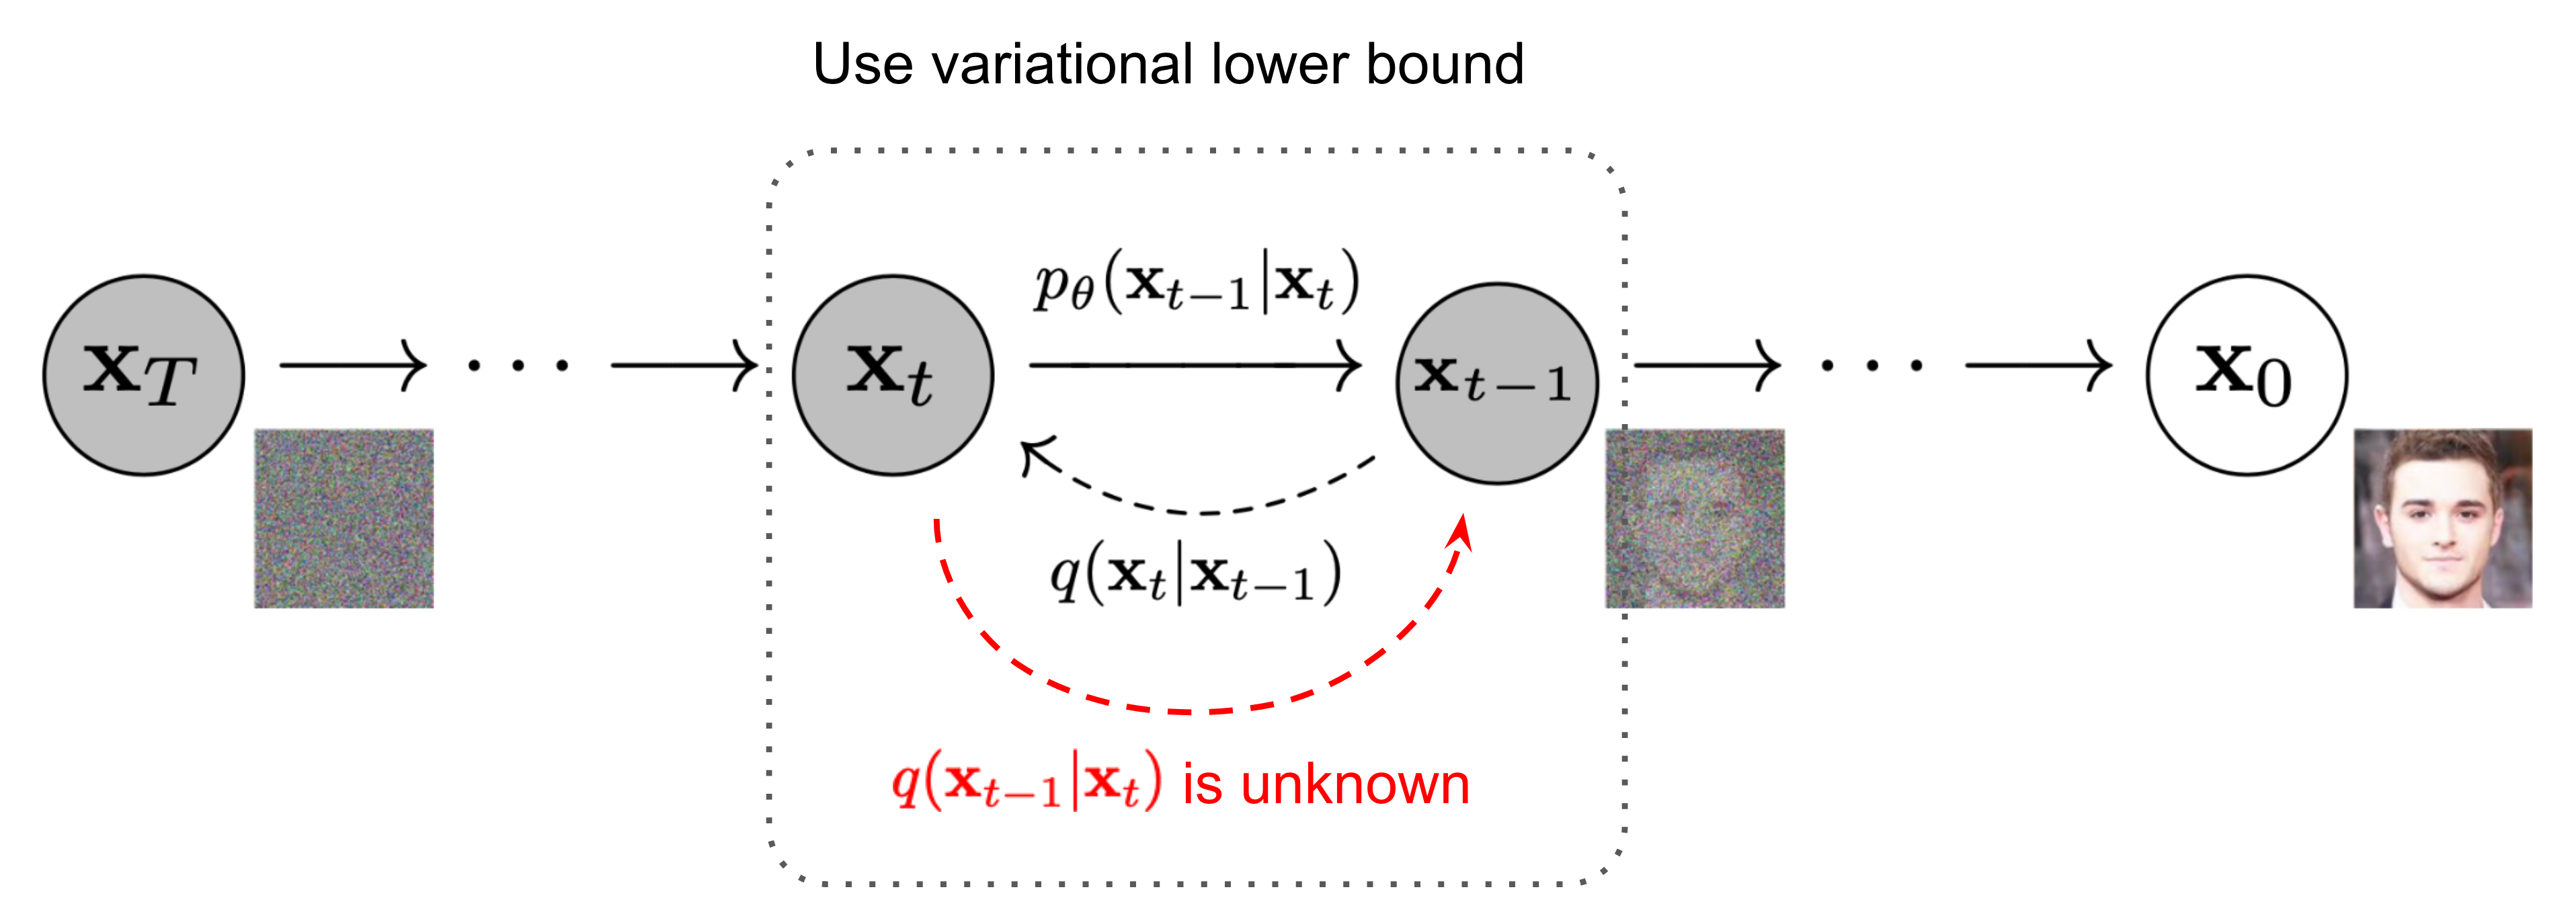

* Image source: [Ho et al. 2020](https://arxiv.org/abs/2006.11239) 




먼저 다음 코드를 실행하여 `"segmind/tiny-sd"`의 UNet 컴포넌트를 로드해봅시다. 

In [2]:
from diffusers import  UNet2DConditionModel
model_id = "segmind/tiny-sd"
unet =  UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")

/home/py/venv_list/base/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


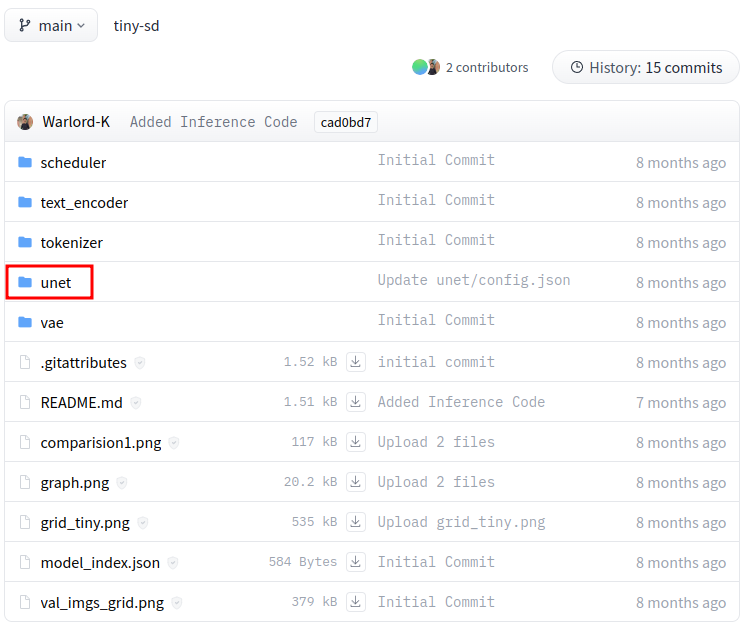

* ["segmind/tiny-sd"의 model repository](https://huggingface.co/segmind/tiny-sd/tree/main)에 접속해보면 위와 같은 모습을 볼 수 있습니다.
* 스테이블 디퓨전은 여러 컴포넌트들이 조합되는 파이프라인의 형태이기 때문에 각 컴포넌트 (e.g. `unet`, `vae`, or `text_encoder`) 별로 하위 폴더를 갖게됩니다. 
* 우리는 스테이블 디퓨전 컴포넌트 가운데서 UNet 컴포넌트를 로드하는 것이기 때문에, `subfolder`를 `unet`으로 설정하겠습니다.

## ONNX Export를 위한 Wrapper 클래스 정의하기

* TensorRT로 모델을 변환하기 위해서는 `Tensor`들을 인풋으로 받고, `Tensor` 혹은 `Tensor`의 튜플을 아웃풋으로 반환하는 형태로 모델을 정의해야 합니다. 
* 허깅페이스에서 제공하는 Module들은 `forward` 메서드에 너무 많은 파라미터들이 정의되어 있고, 아웃풋의 형태가 `Tensor`가 아닌 경우도 많다 보니, ONNX Export에 용이한 형태로 한 차례 바꿔주는 것을 권장합니다.

In [3]:
import torch
import torch.nn as nn


class UNetWrapper(nn.Module):   
    def __init__(self,
                 unet: UNet2DConditionModel,
                 guidance_scale: float = 7.5,):
        super().__init__()
        self.unet =  unet
        # guidance_scale은 denoising 과정에서의 prompt의 강도를 조절합니다.
        # 즉  guidance_scale이 0이면, prompt의 영향력이 없는 
        # unconditional한 denoising이 이루어지고,
        self.guidance_scale = guidance_scale


    def forward(self,
                sample: torch.Tensor,
                timestep: torch.IntTensor,
                encoder_hidden_states: torch.Tensor) -> torch.Tensor:
        """
        Args:
            sample (torch.Tensor): 
                sample은 (batch_size, latent_dim, latent_H, latent_W)의 shape를 갖습니다.
                sample은 UNet이 denoising할 대상에 해당되는 "NOISY" latent tensor라고 이해할 수 있습니다.
                denoising process가 마무리되어 모든 noise가 제거된 sample은 VAE Decoder를 통해 픽셀 이미지로 디코딩됩니다.
            
            timestep (torch.Tensor): (1,)
                
            encoder_hidden_states (torch.Tensor): 
                'text_encoder'로부터 얻은 임베딩 벡터들입니다. 
                UNet의 denoising에 guidance를 제공해주는 요소입니다.
                (batch_size, 2, max_position_embeddings, hidden_dim)의 shape를 갑습니다.
                2번째 dimension이 2인 이유는, 하나는 프롬프트에 대한 임베딩이고, 다른 하나는 empty text("")를 임베딩한 것이기 때문입니다. 
                좀 더 구체적으로 말하면 `enoder_hidden_states[:,0,:,:]`은 prompt를 임베딩한 tensor이고,
                `enoder_hidden_states[:,1,:,:]`은 empty text("")를 임베딩한 tensor입니다.
                전자는 conditional한 denoising을 위해, 후자는 unconditional한 denoising을 위해 사용됩니다.

        Returns:
            noise_pred (torch.Tensor): 
                (batch_size, latent_dim, latent_WH, latent_WH) 
                UNet으로 추정한 Noise입니다.
        """
        sample = torch.cat([sample, sample])
        # sample 2개를 concat하는 이유는 하나는 conditional한 denoising에 
        # 다른 하나는 unconditional한 denoising에 사용할 것이기 때문입니다. 
        # (참고로 prompt가 empty text("")라면 unconditional하다고 볼 수 있습니다.) 

        (batch_size, _2, max_pos_embs, hidden_dim) = encoder_hidden_states.size()
        encoder_hidden_states = (
            encoder_hidden_states
                .permute(1, 0, 2, 3)
                .reshape(2 * batch_size, max_pos_embs, hidden_dim)
        ) 

        noise_pred: torch.Tensor = self.unet.forward(
            sample=sample,
            timestep=timestep[0], 
            # 이걸 timestep.item()으로 바꾸면...TensorRT로 변화할 때 에러가 발생합니다!
            encoder_hidden_states=encoder_hidden_states,
            return_dict=False
        )[0]

        noise_pred_text, noise_pred_uncond = noise_pred.chunk(2)
        noise_pred = (
            noise_pred_uncond +
            self.guidance_scale * (noise_pred_text - noise_pred_uncond)
        )

        return noise_pred  # (batch_size, latent_dim, latent_height, latent_width)

In [5]:
device = "cpu" # device는 "cuda"로 해도 무방합니다.

dtype= torch.float32 # dtype을 FP32로 설정하지만
                     # 이후 FP32 + FP16의 Mixed Precision의 형태로 
                     # 한 번 조정할 것입니다.

# ONNX변환을 위해서는 한 차례 forward operation을 진행해야 합니다.
# 이 때 일종의 예시로서 제공될 input tensor들을 다음과 같이 정의줍니다.
inputs = (
    torch.randn(1, 4, 64, 64).to(device=device, dtype=dtype),
    torch.tensor([1]).int().to(device=device),
    torch.randn(1, 2, 77, 768).to(device=device, dtype=dtype)
) 
# 참고로 이 때 shape에 대한 정보는 해당 모델 레포지토리의 config를 통해 확인하실 수도 있습니다.
# https://huggingface.co/segmind/tiny-sd/blob/main/unet/config.json

input_names = ["sample", "timestep", "encoder_hidden_states"]
output_names =  ["noise"]

# dynamic_axes는 동적으로 사이즈가 변하는 axis를 의미합니다.
# 배치 크기에 따라 사이즈변하는 axis들을 다음과 같이
# dynamic_axes로 정의해줍시다.
dynamic_axes = {
    "sample": {0: "batch_size"},
    "encoder_hidden_states": {0: "batch_size"},
    "noise": {0: "batch_size"},
}
torch.onnx.export(
    model=UNetWrapper(unet).to(device=device, dtype=dtype),
    args=inputs,
    f="onnx/unet.onnx",
    input_names=input_names,
    output_names=output_names,
    opset_version=17,
    dynamic_axes=dynamic_axes,
)


## TensorRT 간보기

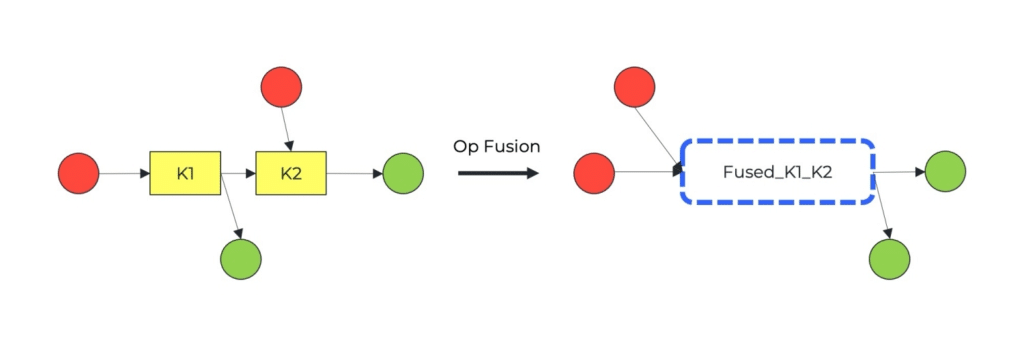

[image source](https://deci.ai/blog/tensorrt-framework-overview/)

* TensorRT는 layer fusion, precision calibration 등등 다양한 optimization **tactic**들을 시험해보며 그 가운데서 현 하드웨어에 최적화된 **tactic**으로 모델의 inference를 최적화해줍니다.
* 마치 하이퍼파라미터 최적화 프레임워크들이 하이퍼파라미터 스페이스를 서치해가며 스코어를 비교하가는 것과 동일한 원리입니다.

## ONNX를 TensorRT로 변환하기

아마 여기까지 잘 따라오셨다면 지금쯤 앞서 실행했던 도커 이미지 빌드가 완료되었을 것입니다.

앞서 빌드했던 `nvcr.io/nvidia/tensorrt:23.10-py3` 이미지를 통해 앞서 export했던 `unet.onnx`를 TensorRT로 변환시켜봅시다.

```bash
docker run --rm -ti \
    -v ./onnx:/onnx \
    -v ./trt:/trt \
    --gpus all \
    nvcr.io/nvidia/tensorrt:23.10-py3 \
trtexec --onnx="/onnx/unet.onnx" \
        --saveEngine="/trt/unet.plan" \
        --verbose \
        --fp16 \
        --minShapes=encoder_hidden_states:1x2x77x768,sample:1x4x64x64 \
        --maxShapes=encoder_hidden_states:2x2x77x768,sample:2x4x64x64
```

여기서
- `--onnx`       : 타겟이 되는 ONNX 파일의 경로를 지정합니다.
- `--saveEngine` : 최종적으로 컨버팅된 TensorRT 파일이 저장될 경로를 지정합니다.
- `--fp16`       : 기존 프리시전(FP32)에 FP16 프리시전을 섞겠다는 것을 의미합니다. (Mixed Precision)
- `--minShapes` & `--maxShapes` : 인풋으로 전달될 텐서들의 사이즈를 지정합니다. `dynamic_axes`를 사용하지 않는 경우라면 굳이 해당 플래그를 지정할 필요가 없습니다. onnx를 export할 때 지정한 사이즈로 shape가 결정될 테니깐요. 하지만 앞서 onnx 파일을 export할 때 `dynamic_axes`를 지정했기 때문에, 본 플래그를 통해서 최소 배치사이즈와 최대 배치사이즈를 명시해주어야 합니다.


## Text Encoder

In [6]:
from transformers import CLIPTextModel
import torch
import torch.nn as nn

text_encoder = CLIPTextModel.from_pretrained("segmind/tiny-sd", 
                                             subfolder="text_encoder")

In [7]:

class TextEncoderWrapper(nn.Module):
    def __init__(self,
                 text_encoder: CLIPTextModel,) -> None:
        super().__init__()
        self.text_encoder = text_encoder
        self.model_id = text_encoder.config._name_or_path

    def forward(self, 
                input_ids: torch.IntTensor, 
                attention_mask: torch.IntTensor,
                ) -> torch.FloatTensor:
        
        batch_size, _2, max_pos_embs = input_ids.size()
        # input_ids는 토크나이저를 통해 얻은 프롬프트와 텅 빈 텍스트("")의 token ID들을 의미합니다.
        # (배치 크기, 2, 최대 토큰 길이)의 shape를 갖습니다.
        # 2번째 axis가 2인 이유는 앞서 UNet에서 설명했던 이유와 동일합니다.
        # 즉, input_ids[:, 0, :]은 토큰화된 프롬프트에 해당되고,
        # input_ids[:, 1, :]은 텅 빈 텍스트("")를 토큰화한 것입니다.
        # 전자는 conditional한 denoising을 위해 후자는 unconditional한 denoising을 위해 사용됩니다.
        
        input_ids = input_ids.reshape(2*batch_size, max_pos_embs)
        attention_mask = attention_mask.reshape(2*batch_size, max_pos_embs)

        result = self.text_encoder.forward(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = result.last_hidden_state
        hidden_dim = text_embeddings.size(-1)
        text_embeddings = text_embeddings.reshape(batch_size, 2, max_pos_embs, hidden_dim)

        return text_embeddings   


In [ ]:
device         = "cpu"
dtype          = torch.float32
input_ids      = torch.randint(0, 10, size=[1, 2, 77])
input_ids      = input_ids.int().to(device=device)
attention_mask = torch.randint(0, 10, size=[1, 2, 77])
attention_mask = attention_mask.int().to(device=device)
inputs         =  (input_ids, attention_mask)

input_names: list[str]  = ["input_ids", "attention_mask"]
output_names: list[str] = ["encoder_hidden_states"]
dynamic_axes            = {"input_ids": {0: "batch_size"},
                           "attention_mask": {0: "batch_size"},
                           "encoder_hidden_states": {0: "batch_size"}}

torch.onnx.export(
    model=TextEncoderWrapper(text_encoder).to(device=device, dtype=dtype),
    args=inputs,
    f="onnx/text_encoder.onnx",
    input_names=input_names,
    output_names=output_names,
    opset_version=17,
    dynamic_axes=dynamic_axes,
)


```bash
docker run --rm -ti \
    -v ./onnx:/onnx \
    -v ./trt:/trt \
    --gpus all \
    nvcr.io/nvidia/tensorrt:23.10-py3 \
    trtexec --onnx="/onnx/text_encoder.onnx" \
        --saveEngine="/trt/text_encoder.plan" \
        --verbose \
        --fp16 \
        --int8 \
        --minShapes=input_ids:1x2x77,attention_mask:1x2x77 \
        --maxShapes=input_ids:2x2x77,attention_mask:2x2x77 
```


## VAE Decoder

In [9]:
from diffusers import AutoencoderKL
import torch.nn as nn
import torch


class VaeDecoderWrapper(nn.Module):
    def __init__(self,
                 vae: AutoencoderKL,
                 scaling_factor: float = 0.18215) -> None:
        super().__init__()
        self.vae = vae
        delattr(self.vae, "encoder")
        self.scaling_factor = scaling_factor

    def forward(self, z: torch.Tensor):
        """
        z: 
            z는 latent tensor를 의미합니다. 
            (batch_size, latent_dim, latent_WH, latent_WH)의 shape를 갖습니다.
        """
        
        image = self.vae.decode(z / self.scaling_factor).sample
        return image

In [10]:
device       = "cpu"
dtype        = torch.float32
z            = torch.randn(1, 4, 64, 64).to(device=device, dtype=dtype)
inputs       = ( z, )
input_names  = ["z"]
output_names = ["image"]
dynamic_axes = {"z": {0: "batch_size"}, "image": {0: "batch_size"}}

In [ ]:
vae = AutoencoderKL.from_pretrained("segmind/tiny-sd", subfolder = "vae")
torch.onnx.export(
    model=VaeDecoderWrapper(vae).to(device=device, dtype=dtype),
    args=inputs,
    f="onnx/vae.onnx",
    input_names=input_names,
    output_names=output_names,
    opset_version=17,
    dynamic_axes=dynamic_axes,
)




```bash
docker run --rm -ti \
    -v ./onnx:/onnx \
    -v ./trt:/trt \
    --gpus all \
    nvcr.io/nvidia/tensorrt:23.10-py3 \
trtexec --onnx="/onnx/vae.onnx" \
        --saveEngine="/trt/vae.plan" \
        --verbose \
        --fp16 \
        --minShapes=z:1x4x64x64 \
        --maxShapes=z:2x4x64x64 
```



## Triton으로 서빙을 위한 Model Repository 만들기

* 모든 과정이 완료되었다면 이제 Triton Inference Server를 통해 컴파일된 TensorRT 모델들을 서빙할 차례입니다.
* 그렇게 하기위해서는 각 모델별로 configuration을 정의된 repository를 다음과 같은 구조로 정의해야합니다.

```bash
repo ─┬─ pipeline ─┬─ 1 
      │            └─ config.pbtxt
      ├─ scheduler ─┬─ 1 ─ scheduler.py
      │             └─ config.pbtxt
      ├─ text_encoder ─┬─ 1 ─ text_encoder.plan
      │                └─ config.pbtxt
      ├─ tokenizer ─┬─ 1 ─ tokenizer.py
      │             └─ config.pbtxt
      ├─ unet ─┬─ 1 ─ unet.plan
      │        └─ config.pbtxt
      └─ vae ─┬─ 1 ─ vae.plan 
              └─ config.pbtxt
```

* 여기서 `1`이라는 이름의 폴더는 모델의 버전을 의미하며, `.plan`으로 저장된 모델의 경우, TensorRT를 통해 서빙되는 모델입니다.
* `.py`라는 확장자로 저장된 모델의 경우, 단순한 python script인데 (앞선 단계에서 별도의 tensorrt로의 변환을 거치지 않은) tokenizer와 schduler가 여기에 해당됩니다.
* `pipeline`은 나머지 컴포넌트들을 모두 조합하는 역할을 합니다.

## Tensor RT 모델의 `config.pbtxt` 정의 예시

먼저 UNet을 예로 들면 다음과 같이 `config.pbtxt` 파일을 정의할 수 있습니다.

```yaml
name: "unet"
platform: "tensorrt_plan"
default_model_filename: "unet.plan"
max_batch_size: 0
# INPUT과 OUTPUT은
# 앞서 ONNX를 export할 때 정의했던 scheme과 동일하게 설정해주면 됩니다.
input: [
  {
    name: "sample"
    data_type: TYPE_FP32
    dims: [-1, 4, 64, 64]
  },
  {
    name: "timestep"
    data_type: TYPE_INT32
    dims: [1]
  },
  {
    name: "encoder_hidden_states"
    data_type: TYPE_FP32
    dims: [-1, 2, 77, 768]
  }
]
output: [
  {
        name: "noise"
    data_type: TYPE_FP32
    dims: [-1, 4, 64, 64]
  }
]
```


## Python 기반 모델의 `config.pbtxt` 정의 예시

schduler나 tokenizer의 경우, Tensor RT가 아닌 파이썬 스크립트의 형태로 서빙되는 모델의 경우, config를 다음과 같이 작성하게 됩니다.


```yaml

name: "scheduler"
backend: "python"
max_batch_size: 0
default_model_filename: "scheduler.py"
input: [
    {
        name: "sample",
        data_type: TYPE_FP32,
        dims: [-1, 4, 64, 64]
    },
    {
        name: "noise",
        data_type: TYPE_FP32,
        dims: [-1, 4, 64, 64]
    },
    {
        name: "i",
        data_type: TYPE_UINT8,
        dims: [1]
    }
]
output: [
    {
        name: "sample",
        data_type: TYPE_FP32,
        dims: [-1, 4, 64, 64]
    },
    {
        name: "timestep",
        data_type: TYPE_INT32,
        dims: [1]
    },
    {
        name: "i",
        data_type: TYPE_UINT8,
        dims: [1]
    }
]
```


## Triton Inference Server 실행하기

모든 준비가 완료되었다면 이제 본격적으로 Triton Inference Server를 실행해보겠습니다.

```bash
docker run -ti --rm --gpus all  \
    -p 3691:8000 \
    -v ./repo:/repo \
    --name triton-server \
    triton \
    tritonserver --model-repository=/repo --exit-on-error=false 
```